<a href="https://colab.research.google.com/github/kangdoung/CS114.K21/blob/master/Do_an_cuoi_ky/Classify_face_celeb_svc_and_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bài toán nhận dạng người nổi tiếng**
* Input: ảnh của 1 trong 5 người  
* Output: tên người nổi tiếng của ảnh đó  
* Dataset gồm ảnh của 5 người: Amee, My Tam,Son Tung MTP, Jack và NDLN.  
Dữ liệu được thu thập từ google image sau đó được cắt và lấy khuôn mặt của mỗi người trên. Thu thập 100 tấm ảnh của mỗi người.  
Dataset được lưu trên google drive ( [*link*](/https://drive.google.com/drive/folders/1YjNGdPb_3equCM7M4tBaXYQpUN8AFIMd?usp=sharing)).


In [10]:
import numpy as np
import pandas as pd
import cv2 #open cv
import os
import matplotlib.pyplot as plt
import os 
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage import io
from skimage.feature import hog
from skimage import exposure

# Load dữ liệu và gán label cho dữ liệu

## Tập TRAIN


In [8]:
def read_img(path):
  image = []
  label = []
  for folder in os.listdir(path):
    for files in os.listdir(path+'/'+folder):
      file_name = path + '/' + folder + '/'+files
      img = io.imread(file_name)
      
      #img = cv2.resize(img,(216,216))
      img = rgb2gray(img)
      # Chuyen hinh anh ve dang cac dang object
      fd_perer, imgs_per = hog(img, orientations=8, pixels_per_cell=(8, 8),
                   cells_per_block=(3, 3), visualize=True)
      imgs_per = exposure.rescale_intensity(imgs_per,in_range = (0,0.04))
      #img_canny = canny(img, sigma=2)
      #hog()

      #imgss = np.round(img.flatten(), 2)
      #print(imgss)
      imgs = np.reshape(imgs_per,216*216)
      #image.append(img)
      image.append(imgs)
      label.append(folder)
  return np.round(np.asarray(image),2),np.asarray(label,dtype='object')

cv2.imread(filename, 0) :

0 = cv2.IMREAD_GRAYSCALE  
tương tụ 1 cho IMREAD_COLOR và -1 cho IMREAD_UNCHANGED

## Tập TEST

### Khác

In [11]:

path_train = 'drive/My Drive/Data_No_Aug/ML/Train'
path_test = 'drive/My Drive/Data_No_Aug/ML/Test'
x_train,y_train = read_img(path_train)
x_test,y_test = read_img(path_test)

## Model


In [ ]:
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

Thêm các thư viện cần thiết

In [12]:
model = SVC(kernel='linear', probability=True)
model.fit(x_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
from sklearn.model_selection import learning_curve, GridSearchCV

In [13]:
pred = model.predict(x_test)

In [15]:
from sklearn.metrics import  accuracy_score
from sklearn.metrics import classification_report

In [16]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

        Amee       0.55      0.69      0.61        16
         MTP       0.90      0.78      0.84        23
       MyTam       0.55      0.73      0.63        15
        NDLN       0.80      0.55      0.65        29
   TranThanh       0.75      0.88      0.81        17

    accuracy                           0.71       100
   macro avg       0.71      0.73      0.71       100
weighted avg       0.74      0.71      0.71       100



In [18]:
accuracy_score(pred, y_test)

0.71

### Nhận xét:
Overfiting

model cho kết quả dự đoán khá thấp do chỉ sử dụng PCA để trích chọn đặc trưng.

### Logistic Regression


# Thử nghiệm bộ dữ liệu với CNN



In [109]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import SGD
import keras
from keras.utils import np_utils
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2
import os

In [46]:
image_size = 50
def read_img(path):
  image = []
  label = []
  for folder in os.listdir(path):
    for files in os.listdir(path+'/'+folder):
      file_name = path + '/' + folder + '/'+files
      img = io.imread(file_name,0)
      
      img = cv2.resize(img,(100,100))
      img = rgb2gray(img)
      # Chuyen hinh anh ve dang cac dang object
      fd_perer, imgs_per = hog(img, orientations=8, pixels_per_cell=(8, 8),
                   cells_per_block=(3, 3), visualize=True)
      imgs_per = exposure.rescale_intensity(imgs_per,in_range = (0,0.04))
      #img_canny = canny(img, sigma=2)
      #hog()

      #imgss = np.round(img.flatten(), 2)
      #print(imgss)
      imgs = np.reshape(imgs_per,100*100)
      #image.append(img)
      image.append(imgs)
      label.append(folder)
  return np.round(np.asarray(image),2),np.asarray(label,dtype='object')
def read_date(path):
  img = []
  label = []
  folders = os.listdir(path)
  for folder in os.listdir(path):
    i = 1
    for files in os.listdir(path+'/'+folder):
      files_name = path + '/'+folder+'/' + files
      
      print(files_name)
      print('STT: {}'.format(i))
      i += 1
      image = cv2.imread(files_name,0)
      
      image = cv2.resize(image, (image_size, image_size))
      images=np.reshape(image, image_size*image_size)
      img.append(images)
      label.append(folder)

  return np.asarray(img),np.asarray(label)

train_path = 'drive/My Drive/data_cnn/Train'
x_train, y_train = read_img(train_path)

test_path = 'drive/My Drive/data_cnn/Test'
x_test, y_test = read_img(test_path)

val_path = 'drive/My Drive/data_cnn/Val'
x_val, y_val = read_img(val_path)

In [47]:
x_train.shape

(3370, 10000)

In [48]:
y_train.shape

(3370,)

In [49]:
x_test.shape

(720, 10000)

In [50]:
y_test.shape

(720,)

In [51]:
x_val.shape

(720, 10000)

In [52]:
print(y_val)

['NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN'
 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN'
 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN'
 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN'
 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN'
 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN'
 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN'
 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN'
 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN'
 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN'
 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN'
 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN'
 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN'
 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN' 'NDLN'
 'NDLN

## Chỉnh sửa các biến đầu vào đề phù hợp với yêu cầu đầu vào của cnn

In [53]:
from sklearn.preprocessing import LabelEncoder
labelencoder_X=LabelEncoder()
y_train = labelencoder_X.fit_transform(y_train)
y_test = labelencoder_X.transform(y_test)
y_val = labelencoder_X.transform(y_val)


In [54]:
x_train = x_train.reshape(x_train.shape[0], 100, 100, 1)
x_val = x_val.reshape(x_val.shape[0], 100, 100, 1)
x_test = x_test.reshape(x_test.shape[0], 100, 100, 1)

In [56]:
y_train = np_utils.to_categorical(y_train, 5)
y_val = np_utils.to_categorical(y_val, 5)
y_test = np_utils.to_categorical(y_test, 5)
print('Dữ liệu y ban đầu ', y_train[0])
print('Dữ liệu y sau one-hot encoding ',y_train[0])

Dữ liệu y ban đầu  [0. 0. 0. 1. 0.]
Dữ liệu y sau one-hot encoding  [0. 0. 0. 1. 0.]


## Xây dựng model

In [110]:
num_classes = 5
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape = (100,100,1), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units = 512, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units = num_classes, activation = 'softmax'))

In [111]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (100,100,1), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Flatten())

model.add(Dense(units = 1024, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation = 'softmax'))


In [112]:
model = Sequential()
model.add(Conv2D(64, (3, 3), border_mode='valid', input_shape =( 100,100,1))) 
model.add(Dropout(0.25)) 
model.add(Conv2D(64, (3, 3))) 
model.add(Dropout(0.25)) 
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Dropout(0.25)) 
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(Dropout(0.25)) 
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())

model.add(Dense(units = 1024, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(5, activation = 'softmax'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(100, 100,..., padding="valid")`
  


In [ ]:
#opt = keras.optimizers.Adam(learning_rate=0.0005)

In [113]:
model.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])
H = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          batch_size=64, epochs=100, verbose=1)

Train on 3370 samples, validate on 720 samples
Epoch 1/100
3370/3370 [==============================] - 13s 4ms/step - loss: 1.4732 - accuracy: 0.4694 - val_loss: 1.7346 - val_accuracy: 0.2875
Epoch 2/100
3370/3370 [==============================] - 11s 3ms/step - loss: 1.0467 - accuracy: 0.6326 - val_loss: 1.1996 - val_accuracy: 0.5444
Epoch 3/100
3370/3370 [==============================] - 11s 3ms/step - loss: 0.8483 - accuracy: 0.7080 - val_loss: 1.0416 - val_accuracy: 0.6347
Epoch 4/100
3370/3370 [==============================] - 11s 3ms/step - loss: 0.6638 - accuracy: 0.7656 - val_loss: 1.3765 - val_accuracy: 0.5111
Epoch 5/100
3370/3370 [==============================] - 11s 3ms/step - loss: 0.5103 - accuracy: 0.8193 - val_loss: 1.8147 - val_accuracy: 0.4542
Epoch 6/100
3370/3370 [==============================] - 11s 3ms/step - loss: 0.4055 - accuracy: 0.8555 - val_loss: 1.3365 - val_accuracy: 0.5486
Epoch 7/100
3370/3370 [==============================] - 11s 3ms/step - loss:

KeyboardInterrupt: ignored

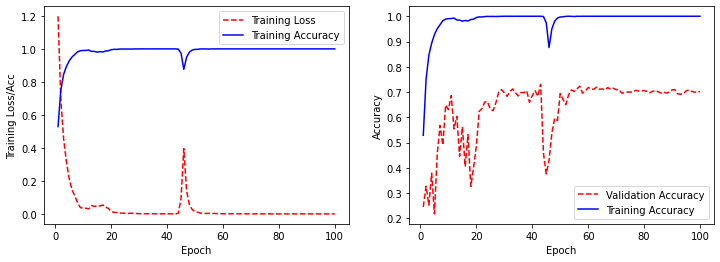

In [98]:
# Get training and test loss histories
training_loss = H.history['loss']
training_acc = H.history['accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

fig=plt.figure(figsize=(12, 4))
# Visualize loss history
fig.add_subplot(121)
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, training_acc, 'b-')
plt.legend(['Training Loss', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Training Loss/Acc')

# Get training and test loss histories
val_acc = H.history['val_accuracy']
training_acc = H.history['accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(val_acc) + 1)

# Visualize loss history
fig.add_subplot(122)
plt.plot(epoch_count, val_acc, 'r--')
plt.plot(epoch_count, training_acc, 'b-')
plt.legend(['Validation Accuracy', 'Training Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.show();

In [99]:
# 9. Đánh giá model với dữ liệu test set
score = model.evaluate(x_test, y_test)
print(score)

720/720 [==============================] - 0s 456us/step
[2.459409761428833, 0.625]


In [ ]:
model.save('drive/My Drive/data_cnn/model_at_12_12am')

### Dự đoán ảnh

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving M63.jpg to M63.jpg


In [ ]:
img = cv2.imread('M63.jpg', 0)
img_show = cv2.imread('M63.jpg', 0)

In [ ]:
model = keras.models.load_model('drive/My Drive/data_cnn/model_at_12_12am')

In [ ]:
img = cv2.resize(img, (50,50), interpolation = cv2.INTER_AREA)
img_pre = []
img_pre.append(img)
img_pre = np.asarray(img_pre)
img_pre = img_pre.reshape(img_pre.shape[0], 50, 50, 1)

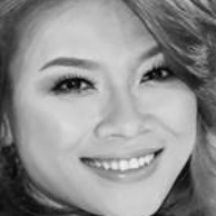

Dự đoán là: Ninh Dương Lan Ngọc


In [ ]:
cv2_imshow(img_show)
if (model.predict_classes(img_pre) == 0):
  print("Dự đoán là: Amee")
elif (model.predict_classes(img_pre) == 1):
  print("Dự đoán là: MTP")
elif (model.predict_classes(img_pre) == 3):
  print("Dự đoán là: Ninh Dương Lan Ngọc")
elif (model.predict_classes(img_pre) == 2):
  print("Dự đoán là: Mỹ Tâm")
else:
  print("Dự đoán là: Trấn Thành")